## Lasso Regression for train3/test2 (mostly duplicated from submission4 notebook)
(Lasso regression is added at the bottom of the notebook - I will)

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import metrics
import warnings; warnings.simplefilter('ignore')

In [22]:
train3 = pd.read_csv('./datasets/train3.csv')
test2 = pd.read_csv('./datasets/test2.csv')
train3.set_index('Id', inplace=True)
test2.set_index('Id', inplace=True)

## This Submission:
   Dummify Neighborhoods

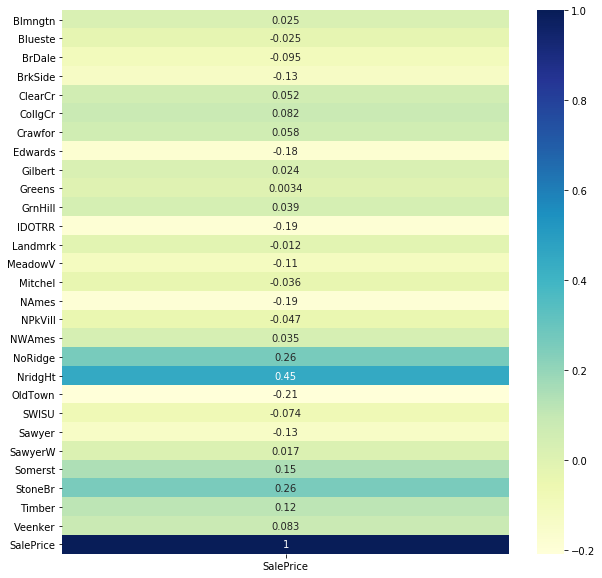

In [24]:
train_nb_dum = pd.get_dummies(train3['Neighborhood'])
train_nb_dum['SalePrice'] = train3['SalePrice']
plt.figure(figsize=(10,10))
sns.heatmap(train_nb_dum.corr()[['SalePrice']], annot=True, cmap='YlGnBu');

In [25]:
#Pick NoRidge, NridgHt, StoneBr
train3['3nbs'] = train_nb_dum['NoRidge']+train_nb_dum['NridgHt']+train_nb_dum['StoneBr']
test_nb_dum = pd.get_dummies(test2['Neighborhood'])
test2['3nbs'] = test_nb_dum['NoRidge']+test_nb_dum['NridgHt']+test_nb_dum['StoneBr']

In [27]:
def r2_adj(x, y, k):
    lr = LinearRegression()
    lr.fit(x, y)
    null_pred=y.mean()
    null_resids = y-null_pred
    null_sse = (null_resids**2).sum()
    pred = lr.predict(x)
    resids = y - pred
    sse=(resids**2).sum()
    r2 = 1-((sse) / (null_sse))
    n = len(y)
    r2_adj = 1 - (1-r2)*(n-1)/(n-k-1)
    return r2_adj

def run_metrics(x,y, k):
    lr = LinearRegression()
    lr.fit(x, y)
    pred = lr.predict(x)
    resids = y - pred
    r2 = lr.score(x,y)
    mae = metrics.mean_absolute_error(y, pred)
    sse = (resids**2).sum()
    rmse = metrics.mean_squared_error(y, pred, squared=False)
    mse = metrics.mean_squared_error(y, pred)
    r2a = r2_adj(x,y,k)
    print(f'Mean Adjusted errors: {mae}')
    print(f'Sum Squared Errors: {sse}')
    print(f'Mean Square Errors: {mse}' )
    print(f'Root Mean Square Errors: {rmse}')
    print(f'R2: {r2}')
    print(f'Adjusted R2: {r2a}')

In [28]:
features = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Year Built', 'Full Bath', 
            'Qual_Cond', 'lot_liv', 'TotRms AbvGrd', 'Garage Yr Blt', 'Overall Cond', 'Kitchen AbvGr', 'Bedroom AbvGr', 
           'high_qual_fp', 'paved_street', '3nbs']
X = train3[features]
y = train3['SalePrice']
run_metrics(X,y,17)

Mean Adjusted errors: 20878.064730035134
Sum Squared Errors: 2214775945241.8555
Mean Square Errors: 1080905780.9867523
Root Mean Square Errors: 32877.131580883884
R2: 0.8278652496915656
Adjusted R2: 0.8264244369120268


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
linreg=LinearRegression()
linreg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
print(f'R2 Train {linreg.score(X_train, y_train)}')
print(f'RMSE Train {metrics.mean_squared_error(y_train, linreg.predict(X_train), squared=False)}')
print(f'R2 Test {linreg.score(X_test, y_test)}')
print(f'RMSE Test {metrics.mean_squared_error(y_test, linreg.predict(X_test), squared=False)}')

R2 Train 0.8255026262017007
RMSE Train 33292.211118041305
R2 Test 0.831850341419287
RMSE Test 31736.61842320354


In [31]:
test2['SalePrice'] = linreg.predict(test2[features])
test2.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Yr Sold,Sale Type,yr_sold_cond,lot_liv,Qual_Cond,high_qual_fp,paved_street,all_pub,SalePrice,3nbs
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,2006,WD,16048,17625776,48,0,1,1,149626.215604,0
2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,...,2006,WD,8024,19005154,20,0,1,1,174642.487177,0
2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,2006,New,10030,25587584,35,1,1,1,194987.473519,0
1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,2007,WD,12042,8247360,30,0,1,1,109896.528087,0
625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,...,2009,WD,10045,13243000,30,1,1,1,179017.808187,0


In [32]:
#try lasso with train3 data
#import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, LassoCV

In [33]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)


In [36]:
#fit and score the model
l_alphas = np.logspace(0,5, 100)
lasso_cv = LassoCV(alphas = l_alphas, cv=5)
lasso_cv.fit(Z_train, y_train)
print(f'Accuracy Lasso train: {lasso_cv.score(Z_train, y_train)}')
print(f'Accuracy Lasso test: {lasso_cv.score(Z_test, y_test)}')

R2 Lasso train: 0.8196535691780745
R2 Lasso test: 0.8313866252138821


In [37]:
#What is the best alpha for this model?
lasso_cv.alpha_

2420.128264794381

In [38]:
#Coefficients that are 0 are not used to predict sale price in this model
lasso_cv.coef_

array([17156.99437799, 19529.77433542,  8678.30497049,  5593.31317455,
        6274.34262284, 11868.91851932,     0.        ,  7376.47375191,
           0.        ,     0.        ,   480.2207999 ,     0.        ,
       -1671.06861988,    -0.        ,  4520.92863815,     0.        ,
       14850.48810298])

In [39]:
#Predict sale price (again, it is named SalePrice2 since there already was a SalePrice)
test2_sc = sc.transform(test2[features])
test2['SalePrice2'] = lasso_cv.predict(test2_sc)
test2.head()

,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,Utilities,...,Sale Type,yr_sold_cond,lot_liv,Qual_Cond,high_qual_fp,paved_street,all_pub,SalePrice,3nbs,SalePrice2
Id,,,,,,,,,,,,,,,,,,,,,
2658,902301120,190,RM,69.0,9142,Pave,Grvl,Reg,Lvl,AllPub,...,WD,16048,17625776,48,0,1,1,149626.215604,0,164528.140150
2718,905108090,90,RL,NaN,9662,Pave,NaN,IR1,Lvl,AllPub,...,WD,8024,19005154,20,0,1,1,174642.487177,0,194225.250603
2414,528218130,60,RL,58.0,17104,Pave,NaN,IR1,Lvl,AllPub,...,New,10030,25587584,35,1,1,1,194987.473519,0,197190.743500
1989,902207150,30,RM,60.0,8520,Pave,NaN,Reg,Lvl,AllPub,...,WD,12042,8247360,30,0,1,1,109896.528087,0,115133.240768
625,535105100,20,RL,NaN,9500,Pave,NaN,IR1,Lvl,AllPub,...,WD,10045,13243000,30,1,1,1,179017.808187,0,184808.140599


In [40]:
#Create output and save it
output7 = test2[['SalePrice2']]
output7.rename(columns = {'SalePrice2':'SalePrice'}, inplace = True)
output7.head()

,SalePrice
Id,
2658,164528.140150
2718,194225.250603
2414,197190.743500
1989,115133.240768
625,184808.140599


In [41]:
output7.to_csv('./datasets/dana_submission_7.csv')

In [42]:
#Create a datafram of the coeffiecent for each column used to see what can be gotten rid of
train3_coefs = train3[features]
train3_coefs.head()
coefs = pd.DataFrame({'column': train3_coefs.columns, 'coef': linreg.coef_})
coefs

,column,coef
0,Overall Qual,12055.575510
1,Gr Liv Area,21824.570941
2,Garage Area,8727.989153
3,Total Bsmt SF,6526.636336
4,1st Flr SF,7060.440731
5,Year Built,13855.360452
6,Full Bath,1235.578427
7,Qual_Cond,8882.756536
8,lot_liv,-2423.178053
9,TotRms AbvGrd,4509.477037


## Summary
In this notebook, I ran a LASSO regression of the model I originally made in submission4